In [19]:
# SETUP INSTRUCTIONS
# Run each cell below to set up environment
# Make sure to adjust subjectid and path variables
# Run pupillabs test BEFORE this protocol to ensure measurements are as expected
path_base = 'C:/Users/kebl6975/Documents/GitHub/cvd_pupillometry/subjectdata/'
# can add subject number + date
subject_id = 2
subj_base = 'sub-002/pipr-90s-binoc-sub-002_ses-01_dat-20230811' # pipr-sub-subjectID-ses-sesID-dat-date - sub-xxx-ses-xx-dat-yyyymmdd

In [2]:
# Set up stlab
from pyplr import stlab
d = stlab.SpectraTuneLab(password='2294b16eea08a15a')
d.turn_off()

LIGHT HUB login success
User authenticated as: admin
The following addresses are defined: [1, 1004, 1023]
Call get_luminaires() / get_device_info() for more info


<Response [200]>

Light engine is now set up, and so it is now possible to access the methods from the REST API. 

C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:368: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for led, df in self.data.groupby(["led"]):
C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:369: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lkp_tbl = lkp_tbl.append(self.interp_led_spectra(led, df))
C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:369: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lkp_tbl = lkp_tbl.append(self.interp_led_spectra(led, df))
C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:369: FutureWarning: The frame.append method is de

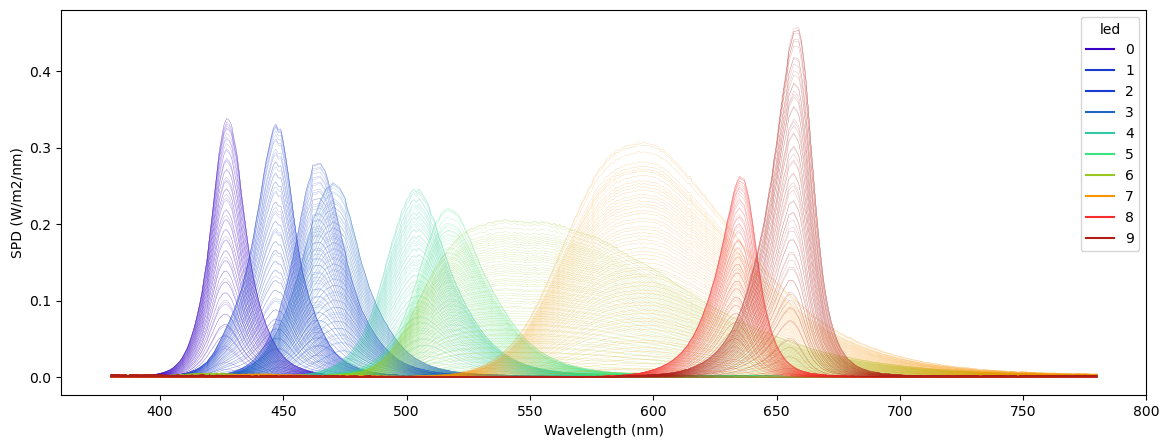

In [3]:
# from pyplr.calibrate import CalibrationContext as calibrationContext
# Calibration - important
import pyplr.calibrate as calb
from importlib import reload
reload(calb)
# file type to be read must be in format of:
# led | intensity | wavelength 1 (380) | wavelength 2 | ... | wavelength n (780)

cc = calb.CalibrationContext(
    'S2_corrected_oo_spectra.csv', binwidth=1)
_ = cc.plot_calibrated_spectra()


In [4]:
# calculate the peak spectral sensitivity for each LED at its maximum intensity setting
cc.lkp.xs(key=4095, level=1).idxmax(axis=1)

led
0    427
1    447
2    465
3    470
4    505
5    517
6    540
7    594
8    635
9    659
dtype: int64

In [5]:
blue_led = 3
red_led = 9
target_lux = 800

# Find the required intensity setting of the blue led for 800 lux
blue_intensity = (cc.lux.loc[blue_led].sub(target_lux)
                                      .abs()
                                      .idxmin())
#                                     .values[0])

# Find the intensity setting of the red led for 800 lux
red_intensity = cc.match(match_led=blue_led,
                         match_led_intensity=blue_intensity,
                         target_led=red_led,
                         match_type='irrad')[1]

C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\CIE.py:5908: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  sss.index = pd.Int64Index(sss.index)


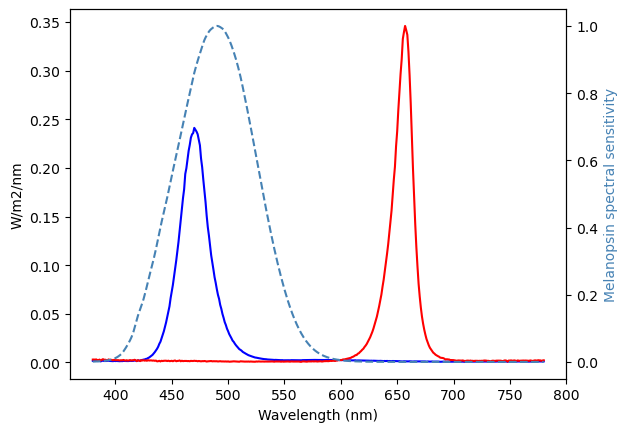

In [6]:
import matplotlib.pyplot as plt
from pyplr.CIE import get_CIES026

fig, ax = plt.subplots()
sss = get_CIES026(binwidth=1)
ax.plot(cc.lkp.loc[(blue_led, blue_intensity)], c='blue')
ax.plot(cc.lkp.loc[(red_led, red_intensity)], c='red')

ax2 = ax.twinx()
ax2.plot(sss['I'], ls='dashed', c='steelblue') # melanopsin = "I"
ax2.set_ylabel('Melanopsin spectral sensitivity', c='steelblue')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('W/m2/nm');

In [7]:
from pyplr import stlab

blue_spec, red_spec = [0]*10, [0]*10
blue_spec[blue_led] = blue_intensity
red_spec[red_led] = red_intensity
d.turn_off()

<Response [200]>

In [9]:
from time import sleep
# import random # not using this library unless we want to randomize stims
from pyplr.pupil import PupilCore
from pyplr.utils import unpack_data_pandas
from pyplr.protocol import input_subject_id, subject_dir
# Connect to Pupil Core
p = PupilCore()
p.check_3d_model()

> Refit the 3d model? [y/n]: 
> Sorry, I didn't understand that.
> Refit the 3d model? [y/n]: n


Please enter subject ID: 002
> Grabbing 570 seconds of pupil.1.3d
> Grabbing 570 seconds of pupil.0.3d
> Waiting for a light to stamp...
> Light stamped on frame.world at -25015.019518
> Waiting for a light to stamp...
> Light stamped on frame.world at -24923.535144999998
> Waiting for a light to stamp...
> Light stamped on frame.world at -24832.212096
> Waiting for a light to stamp...
> Light stamped on frame.world at -24740.934127
> Waiting for a light to stamp...
> Light stamped on frame.world at -24649.494955
> Waiting for a light to stamp...
> Light stamped on frame.world at -24558.243659
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting 

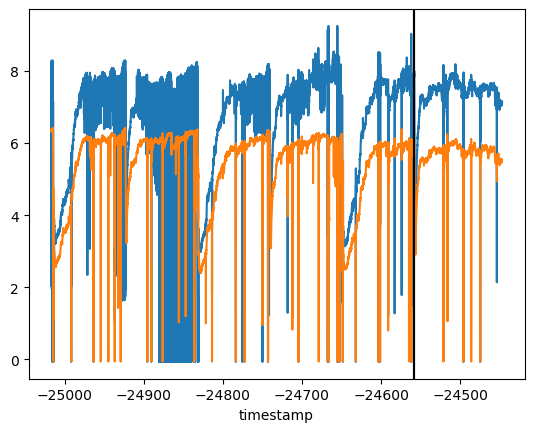

In [10]:
# PIPR STIMS - USE THIS ONE
d.turn_off()
subject_id = input_subject_id()
subj_dir = subject_dir(subject_id)
sleep(2)
ISI = 85 # interstimulus time (seconds) = this variable + 5s due to sleep + processing
num_trials = 6 # total number of trials
run_time = ISI*num_trials + 5*num_trials + 30 # appropriate offset to account for stim duration + sleeps


# Start a new recording called "my_recording"
p.command('R my_recording')

# Wait a few seconds
sleep(2)

# Make an annotation for when the light comes on
annotation = p.new_annotation('LIGHT_ON')

# Start the .light_stamper(...) and .pupil_grabber(...)
# this only captures one eye
# pgr_future = p.pupil_grabber(topic='pupil.1.3d', seconds=25) # time here is TOTAL run time
pgr_future_eye1 = p.pupil_grabber(topic='pupil.1.3d', seconds=run_time) # time here is TOTAL run time
pgr_future_eye0 = p.pupil_grabber(topic='pupil.0.3d', seconds=run_time) # time here is TOTAL run time

sleep(2)
##################################
# Administer light stimulus here #
led_list = [3,9]*3
# random.shuffle(led_list) # use this if stims should be randomized
for led in led_list:
    intensities = [0]*10
    if led == 3:
        intensities[led] = int(blue_intensity)
    else:
        intensities[led] = int(red_intensity)
    lst_future = p.light_stamper(annotation=annotation, timeout=10)
    d.set_spectrum_a(intensities)
    sleep(1.)
    d.turn_off()
    sleep(ISI)
    sleep(5) # make sure there is extra time so that trials do not overlap
##################################

# Wait for the futures
while lst_future.running() or pgr_future_eye0.running() or pgr_future_eye1.running():
    print('Waiting for futures...')
    sleep(1)

# End recording
p.command('r')

# Get the timestamp and pupil data
timestamp = lst_future.result()[1]
data_eye0 = unpack_data_pandas(pgr_future_eye0.result())
data_eye1 = unpack_data_pandas(pgr_future_eye1.result())
# timestamps are displayed in the output as well
# Plot the PLR
ax_0 = data_eye0['diameter_3d'].plot()
ax_0.axvline(x=timestamp, color='k')
ax_1 = data_eye1['diameter_3d'].plot()
ax_1.axvline(x=timestamp, color='k')

In [11]:
# display data from pandas table
data_eye0

,id,topic,method,norm_pos,diameter,confidence,sphere,projected_sphere,circle_3d,diameter_3d,ellipse,location,model_confidence,theta,phi
timestamp,,,,,,,,,,,,,,,
-25017.095457,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.7125745949288614, 0.6151962851060866]",20.660532,0.255532,"{'center': [9.46279075256203, 4.34449666151623...","{'center': [157.27042810000808, 124.1610361878...","{'center': [5.5320281328511385, -2.37326882995...",2.334103,"{'center': [136.8143222263414, 73.882313259631...","[136.8143222263414, 73.88231325963139]",1.0,2.273676,-2.089477
-25017.065648,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.5609150527988669, 0.37735505822440696]",69.245191,0.701347,"{'center': [9.46279075256203, 4.34449666151623...","{'center': [157.27042810000808, 124.1610361878...","{'center': [1.8336834963698072, 3.043483626018...",8.193491,"{'center': [107.69569013738244, 119.5478288209...","[107.69569013738244, 119.54782882091386]",1.0,1.696316,-2.403766
-25017.045027,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.727297122303344, 0.6206467129474749]",22.170462,0.238248,"{'center': [9.46279075256203, 4.34449666151623...","{'center': [157.27042810000808, 124.1610361878...","{'center': [5.858987847525385, -2.494072927190...",2.492232,"{'center': [139.64104748224204, 72.83583111408...","[139.64104748224204, 72.83583111408483]",1.0,2.289011,-2.049397
-25017.019377,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.7333100562067622, 0.6048276069237615]",20.974216,0.288497,"{'center': [9.46279075256203, 4.34449666151623...","{'center': [157.27042810000808, 124.1610361878...","{'center': [5.9289517875634035, -2.12197632562...",2.342666,"{'center': [140.79553079169833, 75.87309947063...","[140.79553079169833, 75.8730994706378]",1.0,2.242393,-2.020144
-25016.994651,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.7362090691731368, 0.6177954819056035]",22.818089,0.220547,"{'center': [9.46279075256203, 4.34449666151623...","{'center': [157.27042810000808, 124.1610361878...","{'center': [6.034284580926418, -2.422664409520...",2.553584,"{'center': [141.35214128124227, 73.38326747412...","[141.35214128124227, 73.38326747412414]",1.0,2.279922,-2.020502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-24447.146332,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.5367764804031717, 0.4277178838315493]",60.161185,0.963122,"{'center': [9.46279075256203, 4.34449666151623...","{'center': [157.27042810000808, 124.1610361878...","{'center': [1.4499047832828538, 1.966524721444...",7.137786,"{'center': [103.06108423740898, 109.8781663043...","[103.06108423740898, 109.87816630434253]",1.0,1.801662,-2.484964
-24447.130693,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.5376873559033848, 0.42803182746446344]",60.142419,0.957577,"{'center': [9.46279075256203, 4.34449666151623...","{'center': [157.27042810000808, 124.1610361878...","{'center': [1.4689177868500272, 1.957621683409...",7.133010,"{'center': [103.23597233344988, 109.8178891268...","[103.23597233344988, 109.81788912682302]",1.0,1.802542,-2.482158
-24447.116648,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.536862777784348, 0.4278632517134654]",60.029894,0.955428,"{'center': [9.46279075256203, 4.34449666151623...","{'center': [157.27042810000808, 124.1610361878...","{'center': [1.4526697991564337, 1.963343907224...",7.120550,"{'center': [103.07765333459481, 109.8502556710...","[103.07765333459481, 109.85025567101465]",1.0,1.801977,-2.484612


In [12]:
data_eye1

,id,topic,method,norm_pos,diameter,confidence,sphere,projected_sphere,circle_3d,diameter_3d,ellipse,location,model_confidence,theta,phi
timestamp,,,,,,,,,,,,,,,
-25017.095651,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.35615691642623903, 0.7344128885996122]",84.065162,0.910955,"{'center': [4.058156853312371, -3.494274642731...","{'center': [130.89456387528844, 65.82608821201...","{'center': [-2.050754583332499, -3.72024527578...",6.338925,"{'center': [68.3821279538379, 50.9927253888744...","[68.3821279538379, 50.99272538887447]",1.0,1.592542,-2.199342
-25017.078585,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.3557547130697683, 0.7345511739679771]",84.109655,0.916953,"{'center': [4.058156853312371, -3.494274642731...","{'center': [130.89456387528844, 65.82608821201...","{'center': [-2.0572219126370452, -3.7229788899...",6.343332,"{'center': [68.30490490939552, 50.966174598148...","[68.30490490939552, 50.966174598148406]",1.0,1.592805,-2.200116
-25017.059938,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.3561700877576402, 0.7342442054692234]",83.895413,0.892054,"{'center': [4.058156853312371, -3.494274642731...","{'center': [130.89456387528844, 65.82608821201...","{'center': [-2.0498184015110192, -3.7176862313...",6.325314,"{'center': [68.38465684946692, 51.025112549909...","[68.38465684946692, 51.0251125499091]",1.0,1.592296,-2.199227
-25017.043907,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.35572595519319483, 0.7341949701803752]",84.081205,0.876492,"{'center': [4.058156853312371, -3.494274642731...","{'center': [130.89456387528844, 65.82608821201...","{'center': [-2.057574733635989, -3.71756111151...",6.341251,"{'center': [68.29938339709341, 51.034565725367...","[68.29938339709341, 51.03456572536798]",1.0,1.592284,-2.200150
-25017.026792,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.35623988231769177, 0.7342239451298451]",84.041422,0.882718,"{'center': [4.058156853312371, -3.494274642731...","{'center': [130.89456387528844, 65.82608821201...","{'center': [-2.0493697639466832, -3.7172226718...",6.336910,"{'center': [68.39805740499682, 51.029002535069...","[68.39805740499682, 51.02900253506974]",1.0,1.592251,-2.199173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-24447.178480,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.3865527137651208, 0.6667657970229068]",74.297535,0.905890,"{'center': [4.058156853312371, -3.494274642731...","{'center': [130.89456387528844, 65.82608821201...","{'center': [-1.5502745911351452, -2.6614294114...",5.545774,"{'center': [74.21812104290319, 63.980966971601...","[74.21812104290319, 63.980966971601894]",1.0,1.490570,-2.142913
-24447.156788,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.3863931515213194, 0.6662629490595073]",74.221110,0.914995,"{'center': [4.058156853312371, -3.494274642731...","{'center': [130.89456387528844, 65.82608821201...","{'center': [-1.5525171035947611, -2.6541269855...",5.540409,"{'center': [74.18748509209333, 64.077513780574...","[74.18748509209333, 64.0775137805746]",1.0,1.489865,-2.143207
-24447.136379,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.38676235401630205, 0.6667572514900032]",74.337478,0.916682,"{'center': [4.058156853312371, -3.494274642731...","{'center': [130.89456387528844, 65.82608821201...","{'center': [-1.5471947376205906, -2.6610437281...",5.548550,"{'center': [74.25837197112999, 63.982607713919...","[74.25837197112999, 63.982607713919386]",1.0,1.490532,-2.142561


In [13]:
import os  

# os.makedirs('C:/Users/kebl6975/Documents/GitHub/cvd_pupillometry/subjectdata', exist_ok=True) 

data_eye0.to_csv(path_base + subj_base + '-eye0.csv')
data_eye1.to_csv(path_base + subj_base + '-eye1.csv')

**DATA PROCESSING BEGINS BELOW**

In [14]:
samples_eye0 = data_eye0
samples_eye1 = data_eye1

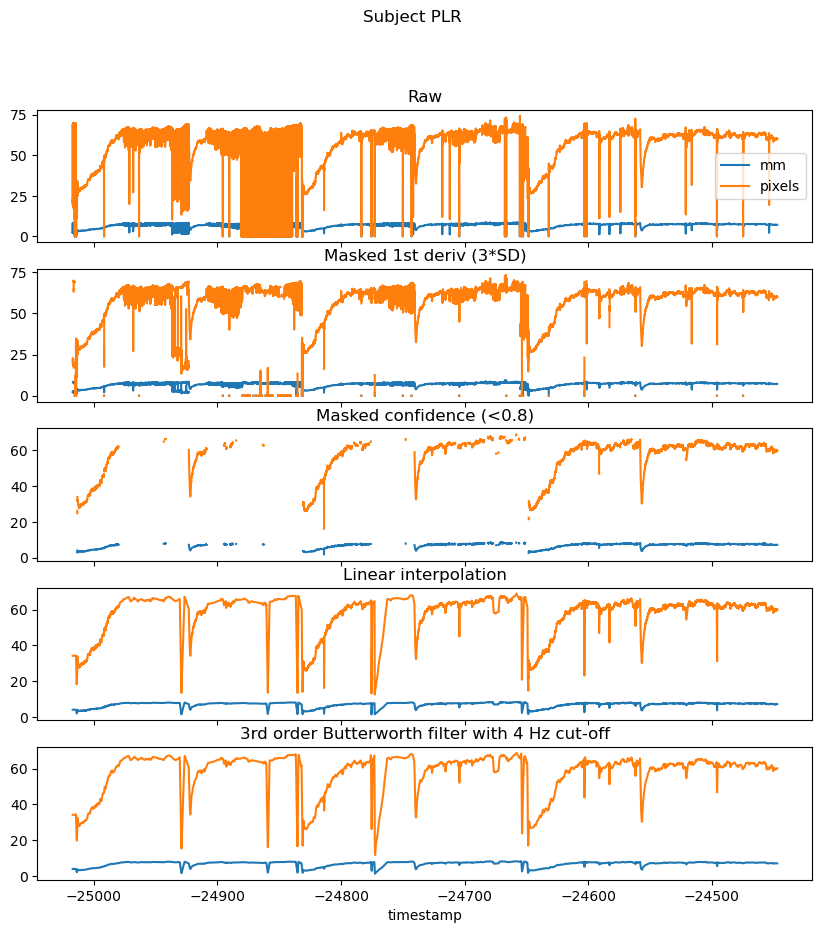

In [15]:
from pyplr import graphing
from pyplr import preproc

# Sampling frequency
SAMPLE_RATE = 120

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
#f, axs = graphing.pupil_preprocessing(nrows=4, subject='Example')
fig, axs = plt.subplots(5, sharex=True, figsize=(10,10))
fig.suptitle('Subject PLR')

# Plot the raw data
samples_eye0[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples_eye0 = preproc.mask_pupil_first_derivative(
    samples_eye0, threshold=3.0, mask_cols=pupil_cols)
samples_eye0[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples_eye0 = preproc.mask_pupil_confidence(
    samples_eye0, threshold=0.8, mask_cols=pupil_cols)
samples_eye0[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples_eye0 = preproc.interpolate_pupil(
    samples_eye0, interp_cols=pupil_cols)
samples_eye0[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples_eye0 = preproc.butterworth_series(
    samples_eye0, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples_eye0[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

In [16]:
# export butterworth processed sample data for eye 0
samples_eye0.to_csv(path_base + subj_base + '-butterworth-eye0.csv') # raw data

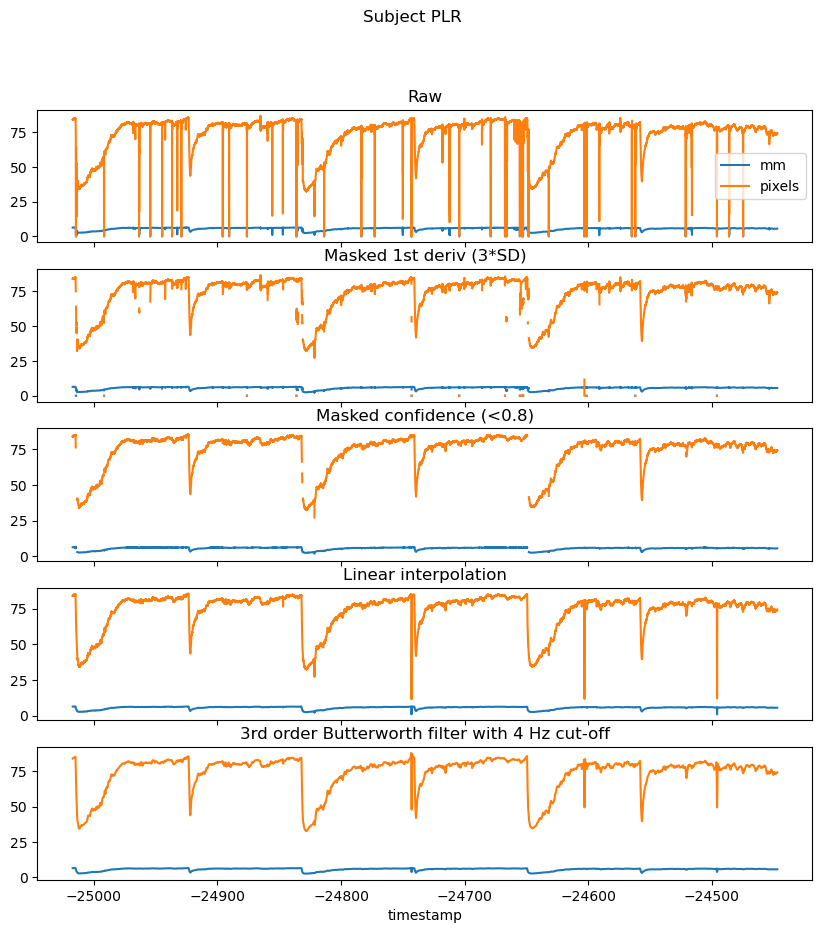

In [17]:
# Sampling frequency
SAMPLE_RATE = 120

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
#f, axs = graphing.pupil_preprocessing(nrows=4, subject='Example')
fig, axs = plt.subplots(5, sharex=True, figsize=(10,10))
fig.suptitle('Subject PLR')

# Plot the raw data
samples_eye1[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples_eye1 = preproc.mask_pupil_first_derivative(
    samples_eye1, threshold=3.0, mask_cols=pupil_cols)
samples_eye1[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples_eye1 = preproc.mask_pupil_confidence(
    samples_eye1, threshold=0.8, mask_cols=pupil_cols)
samples_eye1[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples_eye1 = preproc.interpolate_pupil(
    samples_eye1, interp_cols=pupil_cols)
samples_eye1[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples_eye1 = preproc.butterworth_series(
    samples_eye1, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples_eye1[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

In [18]:
# export butterworth processed sample data for eye 1
samples_eye1.to_csv(path_base + subj_base + '-butterworth-eye1.csv') # raw data
# can stop here if necessary

**CAN STOP HERE AND DO ANALYSIS LATER**

In [83]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [84]:
# df_pipr = pd.read_csv("C:/Users/kebl6975/Documents/GitHub/cvd_pupillometry/subjectdata/sub-999_ses-02_dat-20230419.csv")
df_pipr_eye0 = pd.read_csv(path_base + subj_base + '-eye0.csv')
df_pipr_eye1 = pd.read_csv(path_base + subj_base + '-eye1.csv')

# Print header names
# print(df_pipr.columns)

# Extract the column with header "timestamp"
timestamps_eye0 = df_pipr_eye0["timestamp"]
timestamps_eye1 = df_pipr_eye1["timestamp"]
# Extract the column with header "diameter_3d"
diam_3d_eye0 = df_pipr_eye0["diameter_3d"]
diam_3d_eye1 = df_pipr_eye1["diameter_3d"]

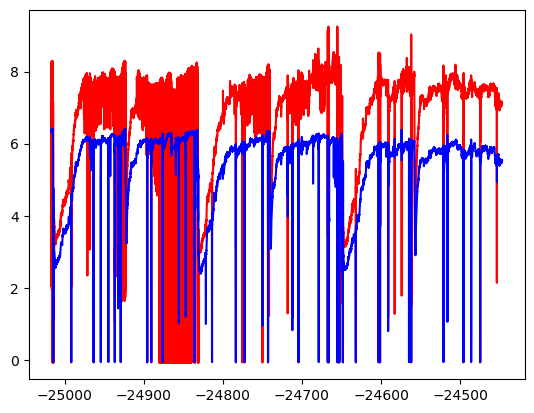

In [85]:
fig = plt.figure()
# plot eye0 in red, eye1 in blue
plt.plot(timestamps_eye0, diam_3d_eye0, 'r') # this should be the smoothed out data - if not, check
plt.plot(timestamps_eye1, diam_3d_eye1, 'b') # this should be the smoothed out data - if not, check

This is copied from the output of cell 11
> Light stamped on frame.world at -25015.019518
> Waiting for a light to stamp...
> Light stamped on frame.world at -24923.535144999998
> Waiting for a light to stamp...
> Light stamped on frame.world at -24832.212096
> Waiting for a light to stamp...
> Light stamped on frame.world at -24740.934127
> Waiting for a light to stamp...
> Light stamped on frame.world at -24649.494955
> Waiting for a light to stamp...
> Light stamped on frame.world at -24558.243659

**Edit Cell Below with Timestamps**

In [23]:
# NEED TO EDIT THIS WITH NEW TIMESTAMPS
# finds indices of each timestamp (or closest one before, if exact match cannot be found).
# finds list of timestamps where condition is true, extracts array of just this, then takes last value (closest stamp)
stamp1 = np.where(timestamps_eye0 <= -25015.019518)[0][-1]
stamp2 = np.where(timestamps_eye0 <= -24923.535144999998)[0][-1]
stamp3 = np.where(timestamps_eye0 <= -24832.212096)[0][-1]
stamp4 = np.where(timestamps_eye0 <= -24740.934127)[0][-1]
stamp5 = np.where(timestamps_eye0 <= -24649.494955)[0][-1]
stamp6 = np.where(timestamps_eye0 <= -24558.243659)[0][-1]
stamps_eye0 = [stamp1, stamp2, stamp3, stamp4, stamp5, stamp6]
stamps_eye0

[89, 4204, 8516, 12670, 16884, 21823]

In [86]:
# NEED TO EDIT THIS WITH NEW TIMESTAMPS
# finds indices of each timestamp (or closest one before, if exact match cannot be found).
# finds list of timestamps where condition is true, extracts array of just this, then takes last value (closest stamp)
stamp1 = np.where(timestamps_eye1 <= -25015.019518)[0][-1]
stamp2 = np.where(timestamps_eye1 <= -24923.535144999998)[0][-1]
stamp3 = np.where(timestamps_eye1 <= -24832.212096)[0][-1]
stamp4 = np.where(timestamps_eye1 <= -24740.934127)[0][-1]
stamp5 = np.where(timestamps_eye1 <= -24649.494955)[0][-1]
stamp6 = np.where(timestamps_eye1 <= -24558.243659)[0][-1]
stamps_eye1 = [stamp1, stamp2, stamp3, stamp4, stamp5, stamp6]
stamps_eye1

[112, 4956, 9741, 14591, 19253, 24202]

In [87]:
from pyplr import utils
from copy import deepcopy

In [88]:
df_data_eye0 = df_pipr_eye0[['timestamp', 'confidence','id','diameter','diameter_3d']]
df_data_eye1 = df_pipr_eye1[['timestamp', 'confidence','id','diameter','diameter_3d']]
df_data_eye1

,timestamp,confidence,id,diameter,diameter_3d
0,-25017.095651,0.910955,1,84.065162,6.338925
1,-25017.078585,0.916953,1,84.109655,6.343332
2,-25017.059938,0.892054,1,83.895413,6.325314
3,-25017.043907,0.876492,1,84.081205,6.341251
4,-25017.026792,0.882718,1,84.041422,6.336910
...,...,...,...,...,...
30167,-24447.178480,0.905890,1,74.297535,5.545774
30168,-24447.156788,0.914995,1,74.221110,5.540409
30169,-24447.136379,0.916682,1,74.337478,5.548550
30170,-24447.115290,0.965520,1,74.364969,5.551252


**Extract ranges from samples based on event timing and sample count, eye 0**

Adapted from extract() from utils.py. Set variables - change as necessary. 
Note: even though ISI is 120, we only want 60s of post measurement

In [27]:
samples_eye0 = df_data_eye0
event_starts_eye0 = stamps_eye0
onset_time = 1
duration_time = 60
offset = -60*onset_time # 60 sample rate, start 1s before light to get baseline
duration = 60*duration_time  # 60 sample rate

# find the indexes of the event starts, and offset by sample count
range_idxs_eye0 = (
    np.searchsorted(samples_eye0.index, event_starts_eye0, "left") + offset
)
range_duration = duration

In [28]:
range_idxs_eye0

array([   29,  4144,  8456, 12610, 16824, 21763], dtype=int64)

In [29]:
# make a hierarchical index for eye 0
samples_eye0["orig_idx"] = samples_eye0.index
midx = pd.MultiIndex.from_product(
    [list(range(len(event_starts_eye0))), list(range(range_duration))],
    names=["event", "onset"],
)

# TODO: can add option for time index here

# get the samples
df_eye0 = pd.DataFrame()
idx = 0
for start_idx in range_idxs_eye0:
    # get the start time and add the required number of indices
    end_idx = start_idx + range_duration - 1  # .loc indexing is inclusive
    if end_idx >= len(samples_eye0):
        end_idx = len(samples_eye0) - 1
    new_df_eye0 = deepcopy(
        samples_eye0.loc[samples_eye0.index[start_idx] : samples_eye0.index[end_idx]]
    )
    #for ba in borrow_attributes:
        #new_df[ba] = events.iloc[idx].get(ba, float("nan"))
    df_eye0 = pd.concat([df_eye0, new_df_eye0])
    idx += 1
    
# if there is an error that doesn't allow the new indices to be set (size mismatch), use the if loop below
if (len(df_eye0)!= len(midx)):
    df_test = df_eye0
    temp_df = deepcopy(df_eye0.loc[df_eye0.index[-1] : df_eye0.index[-1]])
    while len(df_eye0) != len(midx):
        df_eye0= pd.concat([df_eye0, temp_df])

df_eye0.index = midx
print("Extracted ranges for {} events".format(len(event_starts_eye0)))

Extracted ranges for 6 events


C:\Users\kebl6975\AppData\Local\Temp\ipykernel_71512\2141019394.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples_eye0["orig_idx"] = samples_eye0.index


In [30]:
df_eye0.index

MultiIndex([(0,    0),
            (0,    1),
            (0,    2),
            (0,    3),
            (0,    4),
            (0,    5),
            (0,    6),
            (0,    7),
            (0,    8),
            (0,    9),
            ...
            (5, 3590),
            (5, 3591),
            (5, 3592),
            (5, 3593),
            (5, 3594),
            (5, 3595),
            (5, 3596),
            (5, 3597),
            (5, 3598),
            (5, 3599)],
           names=['event', 'onset'], length=21600)

**Extract ranges from samples based on event timing and sample count, eye 1**

Adapted from extract() from utils.py. Set variables - change as necessary. 
Note: even though ISI is 120, we only want 60s of post measurement

In [89]:
samples_eye1 = df_data_eye1
event_starts_eye1 = stamps_eye1 # EDIT
onset_time = 1
duration_time = 60
offset = -60*onset_time # 60 sample rate, start 1s before light to get baseline
duration = 60*duration_time  # 60 sample rate

# find the indexes of the event starts, and offset by sample count
range_idxs_eye1 = (
    np.searchsorted(samples_eye1.index, event_starts_eye1, "left") + offset
)
range_duration = duration

In [90]:
range_idxs_eye1

array([   52,  4896,  9681, 14531, 19193, 24142], dtype=int64)

In [91]:
# make a hierarchical index for eye 1
samples_eye1["orig_idx"] = samples_eye1.index
midx = pd.MultiIndex.from_product(
    [list(range(len(event_starts_eye1))), list(range(range_duration))],
    names=["event", "onset"],
)

# TODO: can add option for time index here

# get the samples
df_eye1 = pd.DataFrame()
idx = 0
for start_idx in range_idxs_eye1:
    # get the start time and add the required number of indices
    end_idx = start_idx + range_duration - 1  # .loc indexing is inclusive
    if end_idx >= len(samples_eye1):
        end_idx = len(samples_eye1) - 1
    new_df_eye1 = deepcopy(
        samples_eye1.loc[samples_eye1.index[start_idx] : samples_eye1.index[end_idx]]
    )
    #for ba in borrow_attributes:
        #new_df[ba] = events.iloc[idx].get(ba, float("nan"))
    df_eye1 = pd.concat([df_eye1, new_df_eye1])
    idx += 1
# if there is an error that doesn't allow the new indices to be set (size mismatch), use the if loop below
if (len(df_eye1)!= len(midx)):
    df_test = df_eye1
    temp_df = deepcopy(df_eye1.loc[df_eye1.index[-1] : df_eye1.index[-1]])
    while len(df_eye1) != len(midx):
        df_eye1= pd.concat([df_eye1, temp_df])
df_eye1.index = midx
print("Extracted ranges for {} events".format(len(event_starts_eye1)))

Extracted ranges for 6 events


C:\Users\kebl6975\AppData\Local\Temp\ipykernel_71512\3597893296.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples_eye1["orig_idx"] = samples_eye1.index


In [92]:
df_eye1.index

MultiIndex([(0,    0),
            (0,    1),
            (0,    2),
            (0,    3),
            (0,    4),
            (0,    5),
            (0,    6),
            (0,    7),
            (0,    8),
            (0,    9),
            ...
            (5, 3590),
            (5, 3591),
            (5, 3592),
            (5, 3593),
            (5, 3594),
            (5, 3595),
            (5, 3596),
            (5, 3597),
            (5, 3598),
            (5, 3599)],
           names=['event', 'onset'], length=21600)

**Re-run the processing on the multi-index data, eye 0**

In [35]:
from pyplr import graphing
from pyplr import preproc
# Calculate baselines
baselines_eye0 = df_eye0.loc[:, range(0, -offset), :].mean(level=0)

# New columns for percent signal change
df_eye0 = preproc.percent_signal_change(
    df_eye0, baselines_eye0, ['diameter_3d', 'diameter'])
df_eye0

C:\Users\kebl6975\AppData\Local\Temp\ipykernel_71512\4183176285.py:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  baselines_eye0 = df_eye0.loc[:, range(0, -offset), :].mean(level=0)


timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                   
0     0     -25016.379161    0.728461   0  69.537748     8.230671        29   
      1     -25016.355875    0.703262   0  69.960937     8.292946        30   
      2     -25016.334588    0.706633   0  69.712952     8.254050        31   
      3     -25016.312119    0.702487   0  69.755389     8.261912        32   
      4     -25016.292029    0.725497   0  63.167822     7.394315        33   
...                   ...         ...  ..        ...          ...       ...   
5     3595  -24492.341171    1.000000   0  60.611742     7.271407     25358   
      3596  -24492.323034    1.000000   0  60.450272     7.250103     25359   
      3597  -24492.302259    1.000000   0  60.692539     7.282734     25360   
      3598  -24492.282943    1.000000   0  60.582965     7.268266     25361   
      3599  -24492.263544    1.000000   0  60.576896     7.267101     25362   

             diameter_3d_pc  diameter_pc  
event onset                               
0     0           60.323191    59.292560  
      1           61.536215    60.261974  
      2           60.778582    59.693906  
      3           60.931721    59.791119  
      4           44.032022    44.700748  
...                     ...          ...  
5     3595        -6.172736    -5.415653  
      3596        -6.447630    -5.667626  
      3597        -6.026581    -5.289570  
      3598        -6.213270    -5.460559  
      3599        -6.228298    -5.470029  

[21600 rows x 8 columns]

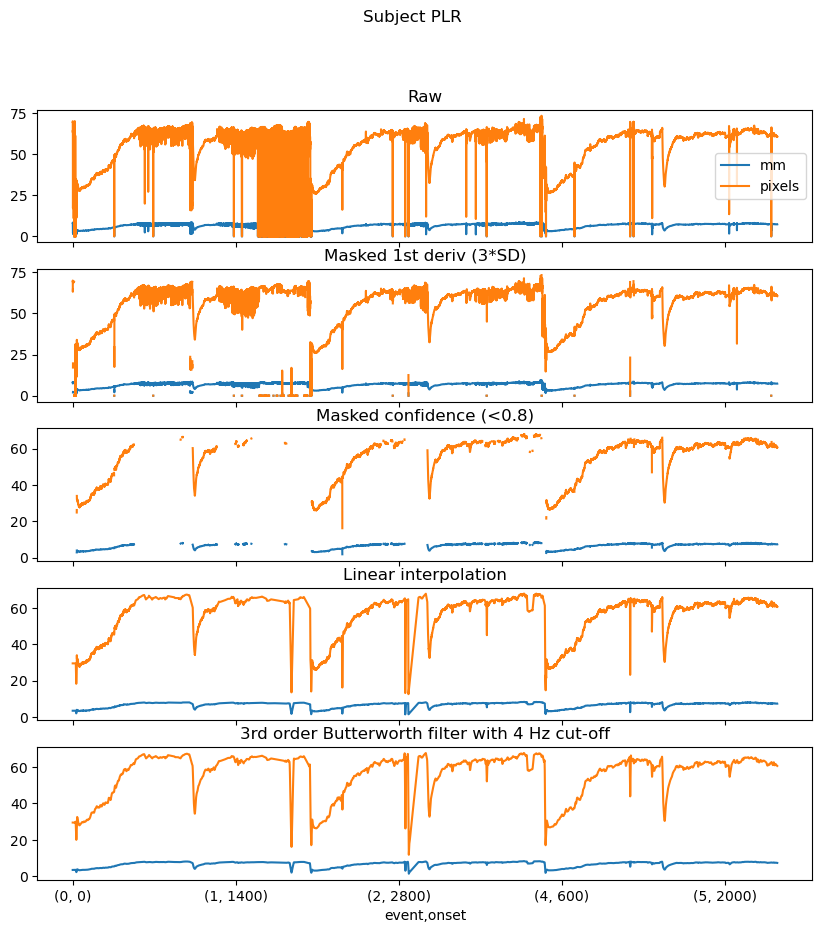

In [36]:
from pyplr import graphing
from pyplr import preproc

# Sampling frequency
SAMPLE_RATE = 120
samples_eye0 = df_eye0

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
#f, axs = graphing.pupil_preprocessing(nrows=4, subject='Example')
fig, axs = plt.subplots(5, sharex=True, figsize=(10,10))
fig.suptitle('Subject PLR')

# Plot the raw data
samples_eye0[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples_eye0 = preproc.mask_pupil_first_derivative(
    samples_eye0, threshold=3.0, mask_cols=pupil_cols)
samples_eye0[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples_eye0 = preproc.mask_pupil_confidence(
    samples_eye0, threshold=0.8, mask_cols=pupil_cols)
samples_eye0[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples_eye0 = preproc.interpolate_pupil(
    samples_eye0, interp_cols=pupil_cols)
samples_eye0[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples_eye0 = preproc.butterworth_series(
    samples_eye0, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples_eye0[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

In [37]:
samples_eye0 # this now has the processed data with blinks removed
# where confidence < 0.8, it interpolates the data
# need to run these to improve the outputs
# TODO: double check what df is after this processing

timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                   
0     0     -25016.379161    0.728461   0  29.451685     3.399126        29   
      1     -25016.355875    0.703262   0  29.451687     3.399126        30   
      2     -25016.334588    0.706633   0  29.451694     3.399127        31   
      3     -25016.312119    0.702487   0  29.451705     3.399128        32   
      4     -25016.292029    0.725497   0  29.451721     3.399130        33   
...                   ...         ...  ..        ...          ...       ...   
5     3595  -24492.341171    1.000000   0  60.675307     7.279577     25358   
      3596  -24492.323034    1.000000   0  60.654088     7.276876     25359   
      3597  -24492.302259    1.000000   0  60.634073     7.274332     25360   
      3598  -24492.282943    1.000000   0  60.615567     7.271981     25361   
      3599  -24492.263544    1.000000   0  60.598806     7.269854     25362   

             diameter_3d_pc  diameter_pc  interpolated  
event onset                                             
0     0           60.323191    59.292560             1  
      1           61.536215    60.261974             1  
      2           60.778582    59.693906             1  
      3           60.931721    59.791119             1  
      4           44.032022    44.700748             1  
...                     ...          ...           ...  
5     3595        -6.172736    -5.415653             0  
      3596        -6.447630    -5.667626             0  
      3597        -6.026581    -5.289570             0  
      3598        -6.213270    -5.460559             0  
      3599        -6.228298    -5.470029             0  

[21600 rows x 9 columns]

In [38]:
df_eye0

timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                   
0     0     -25016.379161    0.728461   0  69.537748     8.230671        29   
      1     -25016.355875    0.703262   0  69.960937     8.292946        30   
      2     -25016.334588    0.706633   0  69.712952     8.254050        31   
      3     -25016.312119    0.702487   0  69.755389     8.261912        32   
      4     -25016.292029    0.725497   0  63.167822     7.394315        33   
...                   ...         ...  ..        ...          ...       ...   
5     3595  -24492.341171    1.000000   0  60.611742     7.271407     25358   
      3596  -24492.323034    1.000000   0  60.450272     7.250103     25359   
      3597  -24492.302259    1.000000   0  60.692539     7.282734     25360   
      3598  -24492.282943    1.000000   0  60.582965     7.268266     25361   
      3599  -24492.263544    1.000000   0  60.576896     7.267101     25362   

             diameter_3d_pc  diameter_pc  
event onset                               
0     0           60.323191    59.292560  
      1           61.536215    60.261974  
      2           60.778582    59.693906  
      3           60.931721    59.791119  
      4           44.032022    44.700748  
...                     ...          ...  
5     3595        -6.172736    -5.415653  
      3596        -6.447630    -5.667626  
      3597        -6.026581    -5.289570  
      3598        -6.213270    -5.460559  
      3599        -6.228298    -5.470029  

[21600 rows x 8 columns]

**Re-run processing on multi-index data, eye 1**

In [93]:
# Calculate baselines
baselines_eye1 = df_eye1.loc[:, range(0, -offset), :].mean(level=0)

# New columns for percent signal change
df_eye1 = preproc.percent_signal_change(
    df_eye1, baselines_eye1, ['diameter_3d', 'diameter'])
df_eye1

C:\Users\kebl6975\AppData\Local\Temp\ipykernel_71512\1788001868.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  baselines_eye1 = df_eye1.loc[:, range(0, -offset), :].mean(level=0)


timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                   
0     0     -25016.125207    0.913176   1  84.598652     6.378474        52   
      1     -25016.108532    0.845831   1  84.463096     6.367137        53   
      2     -25016.096285    0.825548   1  84.546096     6.374319        54   
      3     -25016.078027    0.828009   1  84.502772     6.371990        55   
      4     -25016.060160    0.889779   1  84.481382     6.370295        56   
...                   ...         ...  ..        ...          ...       ...   
5     3595  -24492.839446    0.951792   1  75.777996     5.610083     27737   
      3596  -24492.822251    0.915397   1  75.909115     5.621208     27738   
      3597  -24492.803681    0.991160   1  75.834429     5.612447     27739   
      3598  -24492.792091    0.931376   1  75.749550     5.608260     27740   
      3599  -24492.773553    0.999576   1  75.770469     5.610715     27741   

             diameter_3d_pc  diameter_pc  
event onset                               
0     0            0.020722     0.007787  
      1           -0.157043    -0.152461  
      2           -0.044422    -0.054343  
      3           -0.080949    -0.105558  
      4           -0.107524    -0.130844  
...                     ...          ...  
5     3595        -6.472571    -6.691681  
      3596        -6.287101    -6.530228  
      3597        -6.433155    -6.622193  
      3598        -6.502956    -6.726707  
      3599        -6.462025    -6.700949  

[21600 rows x 8 columns]

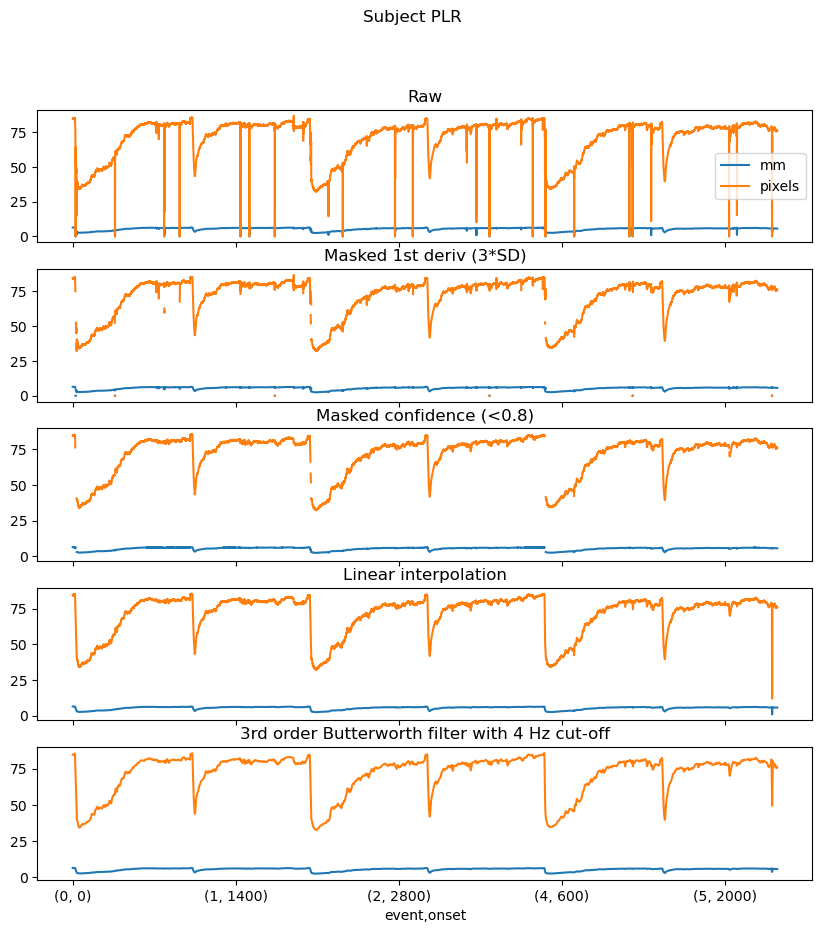

In [94]:
# Sampling frequency
SAMPLE_RATE = 120
samples_eye1 = df_eye1

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
#f, axs = graphing.pupil_preprocessing(nrows=4, subject='Example')
fig, axs = plt.subplots(5, sharex=True, figsize=(10,10))
fig.suptitle('Subject PLR')

# Plot the raw data
samples_eye1[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples_eye1 = preproc.mask_pupil_first_derivative(
    samples_eye1, threshold=3.0, mask_cols=pupil_cols)
samples_eye1[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples_eye1 = preproc.mask_pupil_confidence(
    samples_eye1, threshold=0.8, mask_cols=pupil_cols)
samples_eye1[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples_eye1 = preproc.interpolate_pupil(
    samples_eye1, interp_cols=pupil_cols)
samples_eye1[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples_eye1 = preproc.butterworth_series(
    samples_eye1, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples_eye1[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

In [95]:
samples_eye1 # this now has the processed data with blinks removed
# where confidence < 0.8, it interpolates the data
# need to run these to improve the outputs
# TODO: double check what df is after this processing

timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                   
0     0     -25016.125207    0.913176   1  84.609452     6.379326        52   
      1     -25016.108532    0.845831   1  84.595198     6.378256        53   
      2     -25016.096285    0.825548   1  84.580187     6.377120        54   
      3     -25016.078027    0.828009   1  84.564813     6.375951        55   
      4     -25016.060160    0.889779   1  84.549443     6.374779        56   
...                   ...         ...  ..        ...          ...       ...   
5     3595  -24492.839446    0.951792   1  76.007311     5.627701     27737   
      3596  -24492.822251    0.915397   1  75.953886     5.623817     27738   
      3597  -24492.803681    0.991160   1  75.902850     5.620116     27739   
      3598  -24492.792091    0.931376   1  75.855095     5.616661     27740   
      3599  -24492.773553    0.999576   1  75.811369     5.613504     27741   

             diameter_3d_pc  diameter_pc  interpolated  
event onset                                             
0     0            0.020722     0.007787             0  
      1           -0.157043    -0.152461             0  
      2           -0.044422    -0.054343             0  
      3           -0.080949    -0.105558             0  
      4           -0.107524    -0.130844             0  
...                     ...          ...           ...  
5     3595        -6.472571    -6.691681             0  
      3596        -6.287101    -6.530228             0  
      3597        -6.433155    -6.622193             0  
      3598        -6.502956    -6.726707             0  
      3599        -6.462025    -6.700949             0  

[21600 rows x 9 columns]

In [96]:
df_eye1

timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                   
0     0     -25016.125207    0.913176   1  84.598652     6.378474        52   
      1     -25016.108532    0.845831   1  84.463096     6.367137        53   
      2     -25016.096285    0.825548   1  84.546096     6.374319        54   
      3     -25016.078027    0.828009   1  84.502772     6.371990        55   
      4     -25016.060160    0.889779   1  84.481382     6.370295        56   
...                   ...         ...  ..        ...          ...       ...   
5     3595  -24492.839446    0.951792   1  75.777996     5.610083     27737   
      3596  -24492.822251    0.915397   1  75.909115     5.621208     27738   
      3597  -24492.803681    0.991160   1  75.834429     5.612447     27739   
      3598  -24492.792091    0.931376   1  75.749550     5.608260     27740   
      3599  -24492.773553    0.999576   1  75.770469     5.610715     27741   

             diameter_3d_pc  diameter_pc  
event onset                               
0     0            0.020722     0.007787  
      1           -0.157043    -0.152461  
      2           -0.044422    -0.054343  
      3           -0.080949    -0.105558  
      4           -0.107524    -0.130844  
...                     ...          ...  
5     3595        -6.472571    -6.691681  
      3596        -6.287101    -6.530228  
      3597        -6.433155    -6.622193  
      3598        -6.502956    -6.726707  
      3599        -6.462025    -6.700949  

[21600 rows x 8 columns]

**Convert the index-level samples to time (s)**:

In [43]:
ONSET_IDX = 60
SAMPLE_RATE = 60
new_onset = (df_eye0.index.get_level_values('onset')
                    .unique()
            - ONSET_IDX) / SAMPLE_RATE
df_eye0.index = df_eye0.index.set_levels(
    levels=new_onset, level='onset')

In [44]:
df_eye0["colour"] = ""

In [45]:
for (event, onset) in df_eye0.index:
    if event%2==1:
        df_eye0["colour"][event,onset] = "red"
    else:
        df_eye0["colour"][event,onset] = "blue"

C:\Users\kebl6975\AppData\Local\Temp\ipykernel_71512\1670583221.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eye0["colour"][event,onset] = "blue"
C:\Users\kebl6975\AppData\Local\Temp\ipykernel_71512\1670583221.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eye0["colour"][event,onset] = "red"


In [97]:
ONSET_IDX = 60
SAMPLE_RATE = 60
new_onset = (df_eye1.index.get_level_values('onset')
                    .unique()
            - ONSET_IDX) / SAMPLE_RATE
df_eye1.index = df_eye1.index.set_levels(
    levels=new_onset, level='onset')

In [98]:
df_eye1["colour"] = ""

In [99]:
for (event, onset) in df_eye1.index:
    if event%2==1:
        df_eye1["colour"][event,onset] = "red"
    else:
        df_eye1["colour"][event,onset] = "blue"

C:\Users\kebl6975\AppData\Local\Temp\ipykernel_71512\2599913087.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eye1["colour"][event,onset] = "blue"
C:\Users\kebl6975\AppData\Local\Temp\ipykernel_71512\2599913087.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eye1["colour"][event,onset] = "red"


**Plot the PIPR:**

Text(0.5, 1.0, 'Subject = 2')

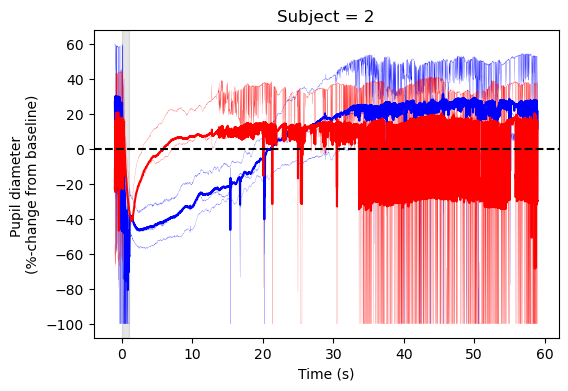

In [50]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(6,4))
for r in range(5):
    if (r==0 or r%2==0):
        c = 'blue'
    else:
        c = 'red'
    df_eye0.loc[r, 'diameter_pc'].plot(
        color=c, lw='.1', ax=ax, legend=False)

# Now show the means
avgs_eye0 = (df_eye0.reset_index()
                .groupby(['colour','onset'], as_index=False)
                .mean())
sns.lineplot(data=avgs_eye0, x='onset', y='diameter_pc', hue='colour',
                palette={'blue':'b','red':'r'}, legend=False)

# Tweak figures
ax.axvspan(0, 1, color='k', alpha=.1)
ax.axhline(0, 0, 1, color='k', ls='--')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Pupil diameter \n(%-change from baseline)')
ax.set_title('Subject = {}'.format(subject_id))

In [51]:
import os
if not os.path.exists(path_base + 'figures'):
    os.makedirs(path_base + 'figures')
# Save the figure in the folder
fig.savefig(path_base + 'figures/' + 'pipr-90s-binoc-sub-002_ses-01_dat-20230811' + '-eye0.png')

In [52]:
df_eye0 # check all is as expected before sending to csv

timestamp  confidence  id   diameter  diameter_3d  \
event onset                                                              
0     -1.000000  -25016.379161    0.728461   0  69.537748     8.230671   
      -0.983333  -25016.355875    0.703262   0  69.960937     8.292946   
      -0.966667  -25016.334588    0.706633   0  69.712952     8.254050   
      -0.950000  -25016.312119    0.702487   0  69.755389     8.261912   
      -0.933333  -25016.292029    0.725497   0  63.167822     7.394315   
...                        ...         ...  ..        ...          ...   
5      58.916667 -24492.341171    1.000000   0  60.611742     7.271407   
       58.933333 -24492.323034    1.000000   0  60.450272     7.250103   
       58.950000 -24492.302259    1.000000   0  60.692539     7.282734   
       58.966667 -24492.282943    1.000000   0  60.582965     7.268266   
       58.983333 -24492.263544    1.000000   0  60.576896     7.267101   

                  orig_idx  diameter_3d_pc  diameter_pc colour  
event onset                                                     
0     -1.000000         29       60.323191    59.292560   blue  
      -0.983333         30       61.536215    60.261974   blue  
      -0.966667         31       60.778582    59.693906   blue  
      -0.950000         32       60.931721    59.791119   blue  
      -0.933333         33       44.032022    44.700748   blue  
...                    ...             ...          ...    ...  
5      58.916667     25358       -6.172736    -5.415653    red  
       58.933333     25359       -6.447630    -5.667626    red  
       58.950000     25360       -6.026581    -5.289570    red  
       58.966667     25361       -6.213270    -5.460559    red  
       58.983333     25362       -6.228298    -5.470029    red  

[21600 rows x 9 columns]

In [53]:
df_eye0.to_csv(path_base + subj_base + '-processed-eye0.csv') # processed data with adjusted onset indices (time in seconds)

<AxesSubplot: xlabel='event,onset'>

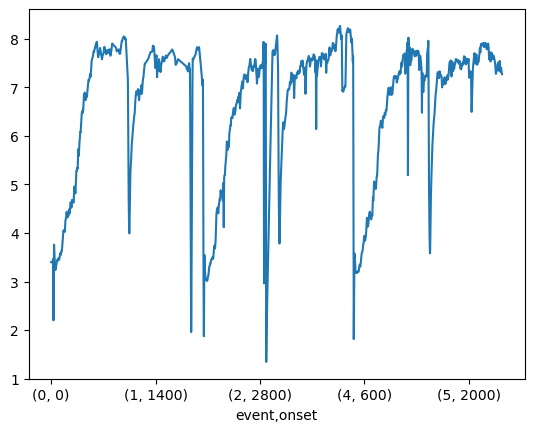

In [54]:
samples_eye0["diameter_3d"].plot()

In [55]:
avgs_eye0.to_csv(path_base + subj_base + '-average-pipr-eye0.csv') # processed data with adjusted onset indices (time in seconds)

In [100]:
df_eye1

timestamp  confidence  id   diameter  diameter_3d  \
event onset                                                              
0     -1.000000  -25016.125207    0.913176   1  84.598652     6.378474   
      -0.983333  -25016.108532    0.845831   1  84.463096     6.367137   
      -0.966667  -25016.096285    0.825548   1  84.546096     6.374319   
      -0.950000  -25016.078027    0.828009   1  84.502772     6.371990   
      -0.933333  -25016.060160    0.889779   1  84.481382     6.370295   
...                        ...         ...  ..        ...          ...   
5      58.916667 -24492.839446    0.951792   1  75.777996     5.610083   
       58.933333 -24492.822251    0.915397   1  75.909115     5.621208   
       58.950000 -24492.803681    0.991160   1  75.834429     5.612447   
       58.966667 -24492.792091    0.931376   1  75.749550     5.608260   
       58.983333 -24492.773553    0.999576   1  75.770469     5.610715   

                  orig_idx  diameter_3d_pc  diameter_pc colour  
event onset                                                     
0     -1.000000         52        0.020722     0.007787   blue  
      -0.983333         53       -0.157043    -0.152461   blue  
      -0.966667         54       -0.044422    -0.054343   blue  
      -0.950000         55       -0.080949    -0.105558   blue  
      -0.933333         56       -0.107524    -0.130844   blue  
...                    ...             ...          ...    ...  
5      58.916667     27737       -6.472571    -6.691681    red  
       58.933333     27738       -6.287101    -6.530228    red  
       58.950000     27739       -6.433155    -6.622193    red  
       58.966667     27740       -6.502956    -6.726707    red  
       58.983333     27741       -6.462025    -6.700949    red  

[21600 rows x 9 columns]

Text(0.5, 1.0, 'Subject = 2')

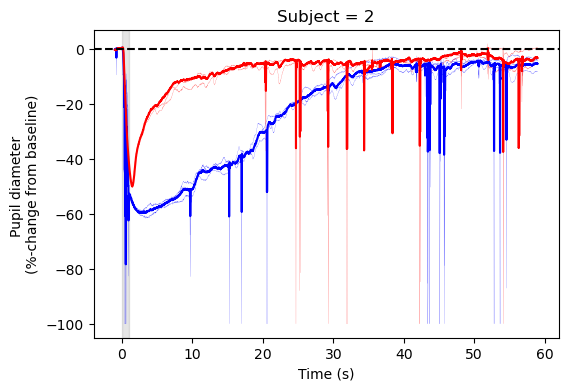

In [101]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(6,4))
for r in range(5):
    if (r==0 or r%2==0):
        c = 'blue'
    else:
        c = 'red'
    df_eye1.loc[r, 'diameter_pc'].plot(
        color=c, lw='.1', ax=ax, legend=False)

# Now show the means
avgs_eye1 = (df_eye1.reset_index()
                .groupby(['colour','onset'], as_index=False)
                .mean())
sns.lineplot(data=avgs_eye1, x='onset', y='diameter_pc', hue='colour',
                palette={'blue':'b','red':'r'}, legend=False)

# Tweak figures
ax.axvspan(0, 1, color='k', alpha=.1)
ax.axhline(0, 0, 1, color='k', ls='--')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Pupil diameter \n(%-change from baseline)')
ax.set_title('Subject = {}'.format(subject_id))

In [102]:
if not os.path.exists(path_base + 'figures'):
    os.makedirs(path_base + 'figures')
# Save the figure in the folder
fig.savefig(path_base + 'figures/' + 'pipr-90s-binoc-sub-002_ses-01_dat-20230811' + '-eye1.png')

In [103]:
df_eye1 # check all is as expected before sending to csv

timestamp  confidence  id   diameter  diameter_3d  \
event onset                                                              
0     -1.000000  -25016.125207    0.913176   1  84.598652     6.378474   
      -0.983333  -25016.108532    0.845831   1  84.463096     6.367137   
      -0.966667  -25016.096285    0.825548   1  84.546096     6.374319   
      -0.950000  -25016.078027    0.828009   1  84.502772     6.371990   
      -0.933333  -25016.060160    0.889779   1  84.481382     6.370295   
...                        ...         ...  ..        ...          ...   
5      58.916667 -24492.839446    0.951792   1  75.777996     5.610083   
       58.933333 -24492.822251    0.915397   1  75.909115     5.621208   
       58.950000 -24492.803681    0.991160   1  75.834429     5.612447   
       58.966667 -24492.792091    0.931376   1  75.749550     5.608260   
       58.983333 -24492.773553    0.999576   1  75.770469     5.610715   

                  orig_idx  diameter_3d_pc  diameter_pc colour  
event onset                                                     
0     -1.000000         52        0.020722     0.007787   blue  
      -0.983333         53       -0.157043    -0.152461   blue  
      -0.966667         54       -0.044422    -0.054343   blue  
      -0.950000         55       -0.080949    -0.105558   blue  
      -0.933333         56       -0.107524    -0.130844   blue  
...                    ...             ...          ...    ...  
5      58.916667     27737       -6.472571    -6.691681    red  
       58.933333     27738       -6.287101    -6.530228    red  
       58.950000     27739       -6.433155    -6.622193    red  
       58.966667     27740       -6.502956    -6.726707    red  
       58.983333     27741       -6.462025    -6.700949    red  

[21600 rows x 9 columns]

In [104]:
df_eye1.to_csv(path_base + subj_base + '-processed-eye1.csv') # processed data with adjusted onset indices (time in seconds)

<AxesSubplot: xlabel='event,onset'>

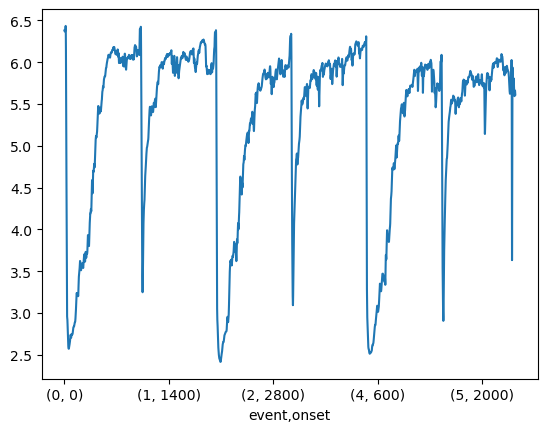

In [105]:
samples_eye1["diameter_3d"].plot()

In [106]:
avgs_eye1.to_csv(path_base + subj_base + '-average-pipr-eye1.csv') # processed data with adjusted onset indices (time in seconds)

**Compute the pupillary light response (optional, skip for now):**

In [ ]:
# adapt this to separate red and blue
from pyplr.plr import PLR

average_plr = df.mean(level=1)['diameter_3d'].to_numpy()
plr = PLR(average_plr,
          sample_rate=60,
          onset_idx=-offset,
          stim_duration=1)

In [ ]:
fig = plr.plot(vel=True, acc=True, print_params=True)

In [ ]:
params = plr.parameters()
params

**Compute the PIPR:**

In [107]:
# code to calculate PIPR at given time
pipr_time = 7 # measure PIPR at t=7s (6s after stimulus turned off)
print(avgs_eye0.loc[avgs_eye0["onset"] == pipr_time])
print(avgs_eye1.loc[avgs_eye1["onset"] == pipr_time])

     colour  onset  event     timestamp  confidence   id   diameter  \
480    blue    7.0    2.0 -24823.994681    1.000000  0.0  30.610659   
4080    red    7.0    3.0 -24732.848317    0.950801  0.0  58.448336   

      diameter_3d      orig_idx  diameter_3d_pc  diameter_pc  
480      3.539352   8916.333333      -39.486748   -39.387294  
4080     6.937638  13319.000000        4.812963     5.083890  
     colour  onset  event     timestamp  confidence   id   diameter  \
480    blue    7.0    2.0 -24823.881310    1.000000  1.0  38.071496   
4080    red    7.0    3.0 -24733.167084    0.961757  1.0  72.028313   

      diameter_3d  orig_idx  diameter_3d_pc  diameter_pc  
480      2.824456   10122.0      -55.256872    -54.92374  
4080     5.341086   15003.0      -14.172111    -13.76339  


In [81]:
# eye 0
blue_d_pipr_eye0 = avgs_eye0["diameter_3d"][480]
red_d_pipr_eye0 = avgs_eye0["diameter_3d"][4080]
blue_d_pipr_pc_eye0 = avgs_eye0["diameter_3d_pc"][480]
red_d_pipr_pc_eye0 = avgs_eye0["diameter_3d_pc"][4080]
pipr_diff_eye0 = red_d_pipr_eye0 - blue_d_pipr_eye0
pipr_pc_diff_eye0 = red_d_pipr_pc_eye0 - blue_d_pipr_pc_eye0
print("PIPR (Absolute Difference), Eye 0: ", pipr_diff_eye0)
print("PIPR (Percent Change), Eye 0: ", pipr_pc_diff_eye0)

PIPR (Absolute Difference), Eye 0:  3.3982856549641562
PIPR (Percent Change), Eye 0:  44.299710377121485


In [108]:
# eye 1 - NEED TO RECALCULATE
blue_d_pipr_eye1 = avgs_eye1["diameter_3d"][480]
red_d_pipr_eye1 = avgs_eye1["diameter_3d"][4080]
blue_d_pipr_pc_eye1 = avgs_eye1["diameter_3d_pc"][480]
red_d_pipr_pc_eye1 = avgs_eye1["diameter_3d_pc"][4080]
pipr_diff_eye1 = red_d_pipr_eye1 - blue_d_pipr_eye1
pipr_pc_diff_eye1 = red_d_pipr_pc_eye1 - blue_d_pipr_pc_eye1
print("PIPR (Absolute Difference), Eye 1: ", pipr_diff_eye1)
print("PIPR (Percent Change), Eye 1: ", pipr_pc_diff_eye1)

PIPR (Absolute Difference), Eye 1:  2.516630558419993
PIPR (Percent Change), Eye 1:  41.08476050452459
